In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys

from pathlib import Path
from IPython.display import display, HTML
from scipy.signal import stft

# Add the root directory of the project to the Python path of the notebook's session
project_root = Path.cwd().parent  # Assuming the notebook is in the "notebooks" folder
sys.path.append(str(project_root))

# Import the DataExtractor class
from src.DataExtraction.DataExtractor import DataExtractor

In [ ]:
def eeg_slices(eeg_data, sampling_freq, window_duration):
    slice_samples = int(sampling_freq*window_duration) #no. of samples per slice
    total_samples = eeg_data.shape[1] #total no. of samples
    slices = []
    for i in range(0,total_samples,slice_samples):
        if i+slice_samples <= total_samples: #skipping the last slice if it doesn't fit in 30s window
            slices.append(eeg_data[:,i:i+slice_samples])
    return slices

## Load Data

In this EDA, only data for Dog1 is analyzed for simplicity

In [3]:
data_extractor = DataExtractor(data_directory="data", test_labels_file="TestLabels.csv")

data_extractor.load_data(dog_ids=["Dog_1"])

Loaded 3935 test labels from c:\Users\User\Documents\Python Projects\SeizureSen\data\TestLabels.csv
Loaded data for 1 dog(s)
  - Interictal segments: 480
  - Preictal segments: 24
  - Test segments: 502


In [4]:
interictal_training = data_extractor.data["interictal"]
preictal_training = data_extractor.data["preictal"]
test_data = data_extractor.data["test"]

In [5]:
test_labels = [label for segment, label in data_extractor.test_labels.items() if "Dog_1" in segment]

## Dataset Composition

In [6]:
# Basic characteristics of the 10-min iEEG segments for dog 1

sample_interictal_training = interictal_training[0]
sample_preictal_training = preictal_training[0]
sample_test_data = test_data[0]

metadata_samples = [sample_preictal_training, sample_interictal_training, sample_test_data]
samples_type = ["Preictal", "Interictal", "Test"]

metadata_dict = {"Sampling Frequency (Hz)": [], "Duration of each Segment (s)": [], "Number of Channels": []}
for sample in metadata_samples:
    metadata_dict["Sampling Frequency (Hz)"].append(round(sample["sampling_frequency"], 2))
    metadata_dict["Duration of each Segment (s)"].append(sample["data_length"])
    metadata_dict["Number of Channels"].append(len(sample["channels"]))

metadata_df = pd.DataFrame(metadata_dict, index=[samples_type])
metadata_df

,Sampling Frequency (Hz),Duration of each Segment (s),Number of Channels
Preictal,399.61,600,16
Interictal,399.61,600,16
Test,399.61,600,16


### Training Set

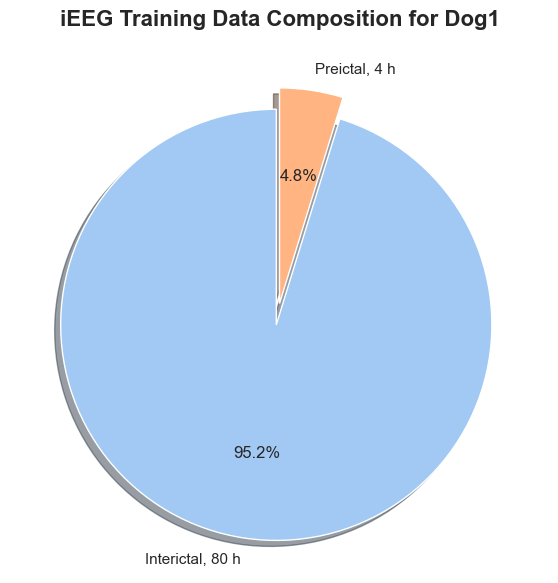

In [7]:
total_time_preictal = sum([int(preictal_segment["data_length"]) for preictal_segment in preictal_training])
total_time_interictal = sum([int(interictal_segment["data_length"]) for interictal_segment in interictal_training])

# Convert times in seconds to hours
preictal_hours = total_time_preictal / 3600 
interictal_hours = total_time_interictal / 3600

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Data for the pie chart
labels = ['Interictal', 'Preictal']
times = [total_time_interictal, total_time_preictal]
hours = [interictal_hours, preictal_hours]

# Combine labels with percentages and times in hours
label_with_details = [
    f"{label}, {time:.0f} h" 
    for label, time in zip(labels, hours)
]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    times,
    labels=label_with_details,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[:len(labels)],  # Use Seaborn pastel palette
    explode=(0.1, 0),  # Slightly separate the preictal sector
    shadow=True
)

plt.title('iEEG Training Data Composition for Dog1', fontsize=16, weight='bold')
plt.show()

### Test set

In [8]:
test_segment_duration = test_data[0]["data_length"]

test_labels_s = pd.Series(test_labels)

test_set_composition_s = test_labels_s.value_counts()
test_set_composition_s.index = ["interictal", "preictal"]
test_set_composition_s

interictal    478
preictal       24
Name: count, dtype: int64

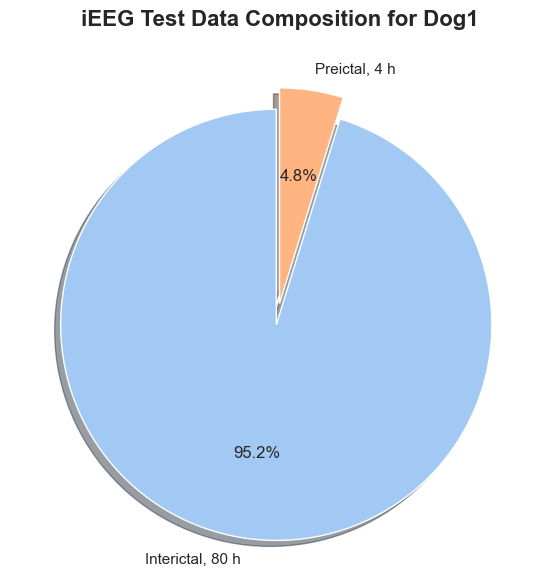

In [9]:
times_test_set_s = test_set_composition_s * test_segment_duration / 3600

[total_time_test_interictal, total_time_test_preictal] = times_test_set_s.tolist()

# Data for the pie chart
labels = ['Interictal', 'Preictal']
times_test_set = [total_time_test_interictal, total_time_test_preictal]

# Combine labels with percentages and times in hours
label_with_details = [
    f"{label}, {time:.0f} h" 
    for label, time in zip(labels, times_test_set)
]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    times_test_set,
    labels=label_with_details,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")[:len(labels)],  # Use Seaborn pastel palette
    explode=(0.1, 0),  # Slightly separate the preictal sector
    shadow=True
)

plt.title('iEEG Test Data Composition for Dog1', fontsize=16, weight='bold')
plt.show()

## Analysis of iEEG Signals in Time Domain

### Time Domain Plots

In [10]:
[preictal_color, interictal_color] = sns.color_palette("pastel")[:len(labels)]

Text(0.5, 0.98, 'iEEG Signals Segment 1 Training Dataset')

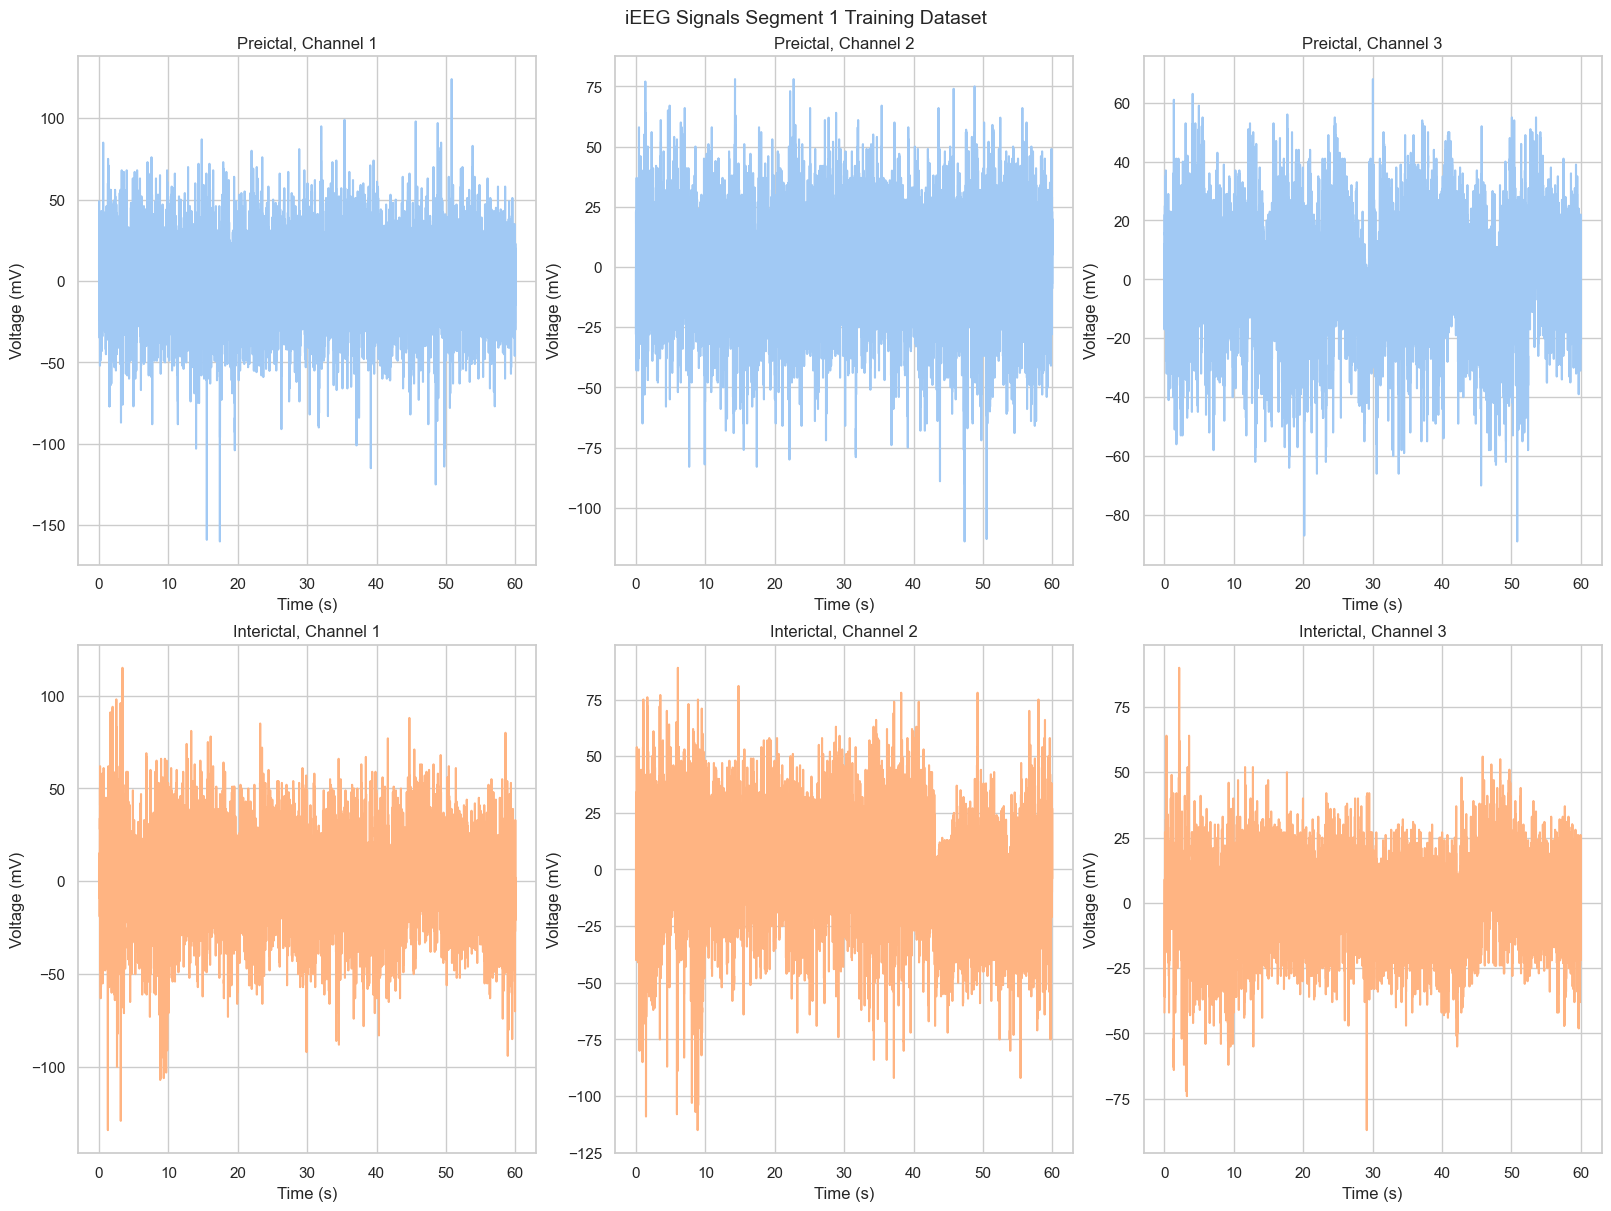

In [11]:
segment_to_plot = 1
channels_to_plot = [1, 2, 3]

sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

time_window = 60
samples_window = round(sampling_freq * time_window)

time = range(samples_window) / sampling_freq

fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(16, 12), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    preictal_training_seg_example = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_training_seg_example = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    sns.lineplot(x=time, y=preictal_training_seg_example, ax=axes[0][idx], color=preictal_color)
    sns.lineplot(x=time, y=interictal_training_seg_example, ax=axes[1][idx], color=interictal_color)
    
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[1][idx].set_title(f"Interictal, Channel {channel}")

    axes[0][idx].set_ylabel("Voltage (mV)")
    axes[1][idx].set_ylabel("Voltage (mV)")

    axes[0][idx].set_xlabel("Time (s)")
    axes[1][idx].set_xlabel("Time (s)")

fig.suptitle(f"iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)


### Descriptive Statistics in Time Domain

In this section, basic time domain statistics (mean, std, max, min) are calculated over 30s-long preictal and interictal iEEG slices. The slices are taken from a subset the training set.

In [13]:
sample_segments_idx = range(0, 24)
slice_time_duration = 30

sample_preictal_segments = [preictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]
sample_interictal_segments =  [interictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]

fs = preictal_training[0]["sampling_frequency"]

# All 30s-long slices are stored in the following lists
all_preictal_slices = []
all_interictal_slices = []

for eeg_segment in sample_preictal_segments:
    all_preictal_slices = all_preictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)
    
for eeg_segment in sample_interictal_segments:
    all_interictal_slices = all_interictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)

In [72]:
print("Number of preictal 30s slices: ", len(all_preictal_slices))
print("Number of interictal 30s slices: ", len(all_interictal_slices))

Number of preictal 30s slices:  480
Number of interictal 30s slices:  480


In [73]:
# The basic time domain statistics are calculated for every 30s-long slices and stored in lists
 
max_voltage_per_channel_preictal = [np.max(segment, axis=1) for segment in all_preictal_slices]
min_voltage_per_channel_preictal = [np.min(segment, axis=1) for segment in all_preictal_slices]
mean_voltage_per_channel_preictal = [np.mean(segment, axis=1) for segment in all_preictal_slices]
std_voltage_per_channel_preictal = [np.std(segment, axis=1) for segment in all_preictal_slices]

max_voltage_per_channel_interictal = [np.max(segment, axis=1) for segment in all_interictal_slices]
min_voltage_per_channel_interictal = [np.min(segment, axis=1) for segment in all_interictal_slices]
mean_voltage_per_channel_interictal = [np.mean(segment, axis=1) for segment in all_interictal_slices]
std_voltage_per_channel_interictal = [np.std(segment, axis=1) for segment in all_interictal_slices]

In [74]:
# Transform the previous lists in pandas dataframes to make analysis easier
# The columns are the channels and the rows are the slices of data

num_channels = len(max_voltage_per_channel_preictal[0])

# Preictal
max_preictal_df = pd.DataFrame(max_voltage_per_channel_preictal,
             columns=[f" Max Ch{x + 1}" for x in range(num_channels)])

min_preictal_df = pd.DataFrame(min_voltage_per_channel_preictal,
             columns=[f" Min Ch{x + 1}" for x in range(num_channels)])

mean_preictal_df = pd.DataFrame(mean_voltage_per_channel_preictal,
             columns=[f" Mean Ch{x + 1}" for x in range(num_channels)])

std_preictal_df = pd.DataFrame(std_voltage_per_channel_preictal,
             columns=[f"Std Ch{x + 1}" for x in range(num_channels)])

# Interictal
max_interictal_df = pd.DataFrame(max_voltage_per_channel_interictal,
             columns=[f" Max Ch{x + 1}" for x in range(num_channels)])

min_interictal_df = pd.DataFrame(min_voltage_per_channel_interictal,
             columns=[f" Min Ch{x + 1}" for x in range(num_channels)])

mean_interictal_df = pd.DataFrame(mean_voltage_per_channel_interictal,
             columns=[f" Mean Ch{x + 1}" for x in range(num_channels)])

std_interictal_df = pd.DataFrame(std_voltage_per_channel_interictal,
             columns=[f"Std Ch{x + 1}" for x in range(num_channels)])

print("shape of mean_preictal_df: ", mean_preictal_df.shape)
print("shape of std_preictal_df: ", std_preictal_df.shape)

shape of mean_preictal_df:  (480, 16)
shape of std_preictal_df:  (480, 16)


In [ ]:
# Run a hypothesis test to see if the std of a eeg 30s-long slice  varies across the channels and/or the class
std_interictal_df.head()

,Std Ch1,Std Ch2,Std Ch3,Std Ch4,Std Ch5,Std Ch6,Std Ch7,Std Ch8,Std Ch9,Std Ch10,Std Ch11,Std Ch12,Std Ch13,Std Ch14,Std Ch15,Std Ch16
0,25.257586,23.087599,16.245881,17.411326,62.802268,14.338019,13.536687,12.854167,21.873309,16.803977,13.683201,15.606678,14.512266,16.232710,13.803710,17.976711
1,21.835206,21.948277,14.196463,15.374707,85.222900,13.221403,11.971280,11.621093,19.919240,15.217804,12.712604,13.895590,14.354624,15.008448,11.965811,14.431870
2,31.827369,31.422088,18.670857,19.612350,67.880196,15.394114,13.578132,13.438815,24.378962,16.418396,14.895754,16.513622,14.491518,15.817799,14.345207,17.095536
3,33.504546,30.768266,24.914371,28.786946,90.201900,21.190840,26.801403,28.863441,26.108690,20.029077,20.011410,20.229437,34.604355,20.209353,21.882729,25.161159
4,43.317719,34.852666,25.848872,28.021935,66.624066,20.221525,19.534721,19.313727,30.005686,22.532803,20.088985,21.994524,20.684657,21.245988,19.646441,24.650427


In [44]:
# Std comparison
avg_std_preictal_s = std_preictal_df.mean()
avg_std_interictal_s = std_interictal_df.mean()
std_comparison_df = pd.DataFrame({
    "Preictal": avg_std_preictal_s,
    "Interictal": avg_std_interictal_s
})

# Mean comparison
avg_mean_preictal_s = mean_preictal_df.mean()
avg_mean_interictal_s = mean_interictal_df.mean()
mean_comparison_df = pd.DataFrame({
    "Preictal": avg_mean_preictal_s,
    "Interictal": avg_mean_interictal_s
})

# Max comparison
avg_max_preictal_s = max_preictal_df.mean()
avg_max_interictal_s = max_interictal_df.mean()
max_comparison_df = pd.DataFrame({
    "Preictal": avg_max_preictal_s,
    "Interictal": avg_max_interictal_s
})

# Min comparison
avg_min_preictal_s = min_preictal_df.mean()
avg_min_interictal_s = min_interictal_df.mean()
min_comparison_df = pd.DataFrame({
    "Preictal": avg_min_preictal_s,
    "Interictal": avg_min_interictal_s
})

# Convert DataFrames to HTML and display side by side
html_content = f"""
<div style="display: flex; gap: 50px;">
    <div>{max_comparison_df.to_html()}</div>
    <div>{min_comparison_df.to_html()}</div>
    <div>{mean_comparison_df.to_html()}</div>
    <div>{std_comparison_df.to_html()}</div>
</div>
"""

display(HTML(html_content))

,Preictal,Interictal
Max Ch1,179.512500,152.000000
Max Ch2,132.154167,118.433333
Max Ch3,89.906250,80.452083
Max Ch4,106.406250,96.266667
Max Ch5,145.595833,162.443750
Max Ch6,84.650000,75.168750
Max Ch7,82.168750,74.189583
Max Ch8,86.650000,82.754167
Max Ch9,125.195833,107.347917
Max Ch10,84.425000,78.531250


### Correlation between Channels

In [22]:
idx_seg_to_analyse_corr = 1

preictal_training_seg = preictal_training[idx_seg_to_analyse_corr - 1]["eeg_data"]
preictal_training_seg_df = pd.DataFrame(preictal_training_seg.T)
preictal_channel_corr = preictal_training_seg_df.corr()

interictal_training_seg = interictal_training[idx_seg_to_analyse_corr - 1]["eeg_data"]
interictal_training_seg_df = pd.DataFrame(interictal_training_seg.T)
interictal_channel_corr = interictal_training_seg_df.corr()


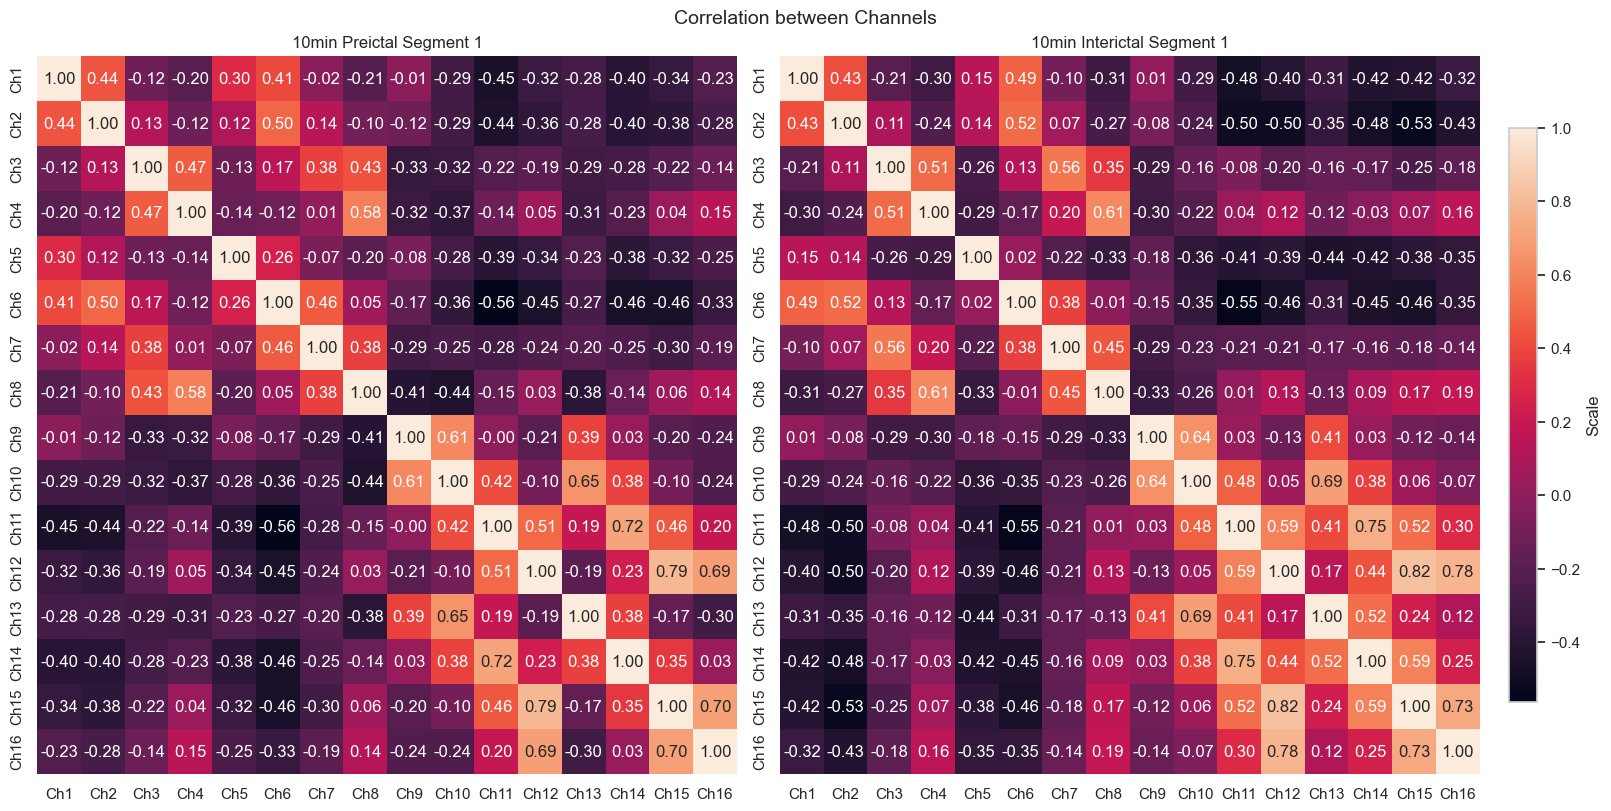

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), constrained_layout=True)

fig.suptitle(f"Correlation between Channels", fontsize=14)

num_channels = len(preictal_channel_corr.columns)
channel_names = [f"Ch{idx + 1}" for idx in range(num_channels)]

# Find the min and max values across both datasets
vmin = min(preictal_channel_corr.values.min(), interictal_channel_corr.values.min())
vmax = max(preictal_channel_corr.values.max(), interictal_channel_corr.values.max())

sns.heatmap(preictal_channel_corr, ax=axes[0], vmin=vmin, vmax=vmax, cbar=False, annot=True, xticklabels=channel_names, yticklabels=channel_names, fmt=".2f")
sns.heatmap(interictal_channel_corr, ax=axes[1], vmin=vmin, vmax=vmax, annot=True, cbar=False, xticklabels=channel_names, yticklabels=channel_names, fmt=".2f")

# Add a single color bar to the side
cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation="vertical", shrink=0.8, pad=0.02)
cbar.set_label("Scale")

axes[0].set_title(f"10min Preictal Segment {idx_seg_to_analyse_corr}")
axes[1].set_title(f"10min Interictal Segment {idx_seg_to_analyse_corr}")

plt.show()

Observations:
- Nearby channels demonstrate a considerable correlation (elements close to the main diagonal)
- Channels further away from each other show lower covariance (elements further away from the main diagonal)

### Autocorrelation

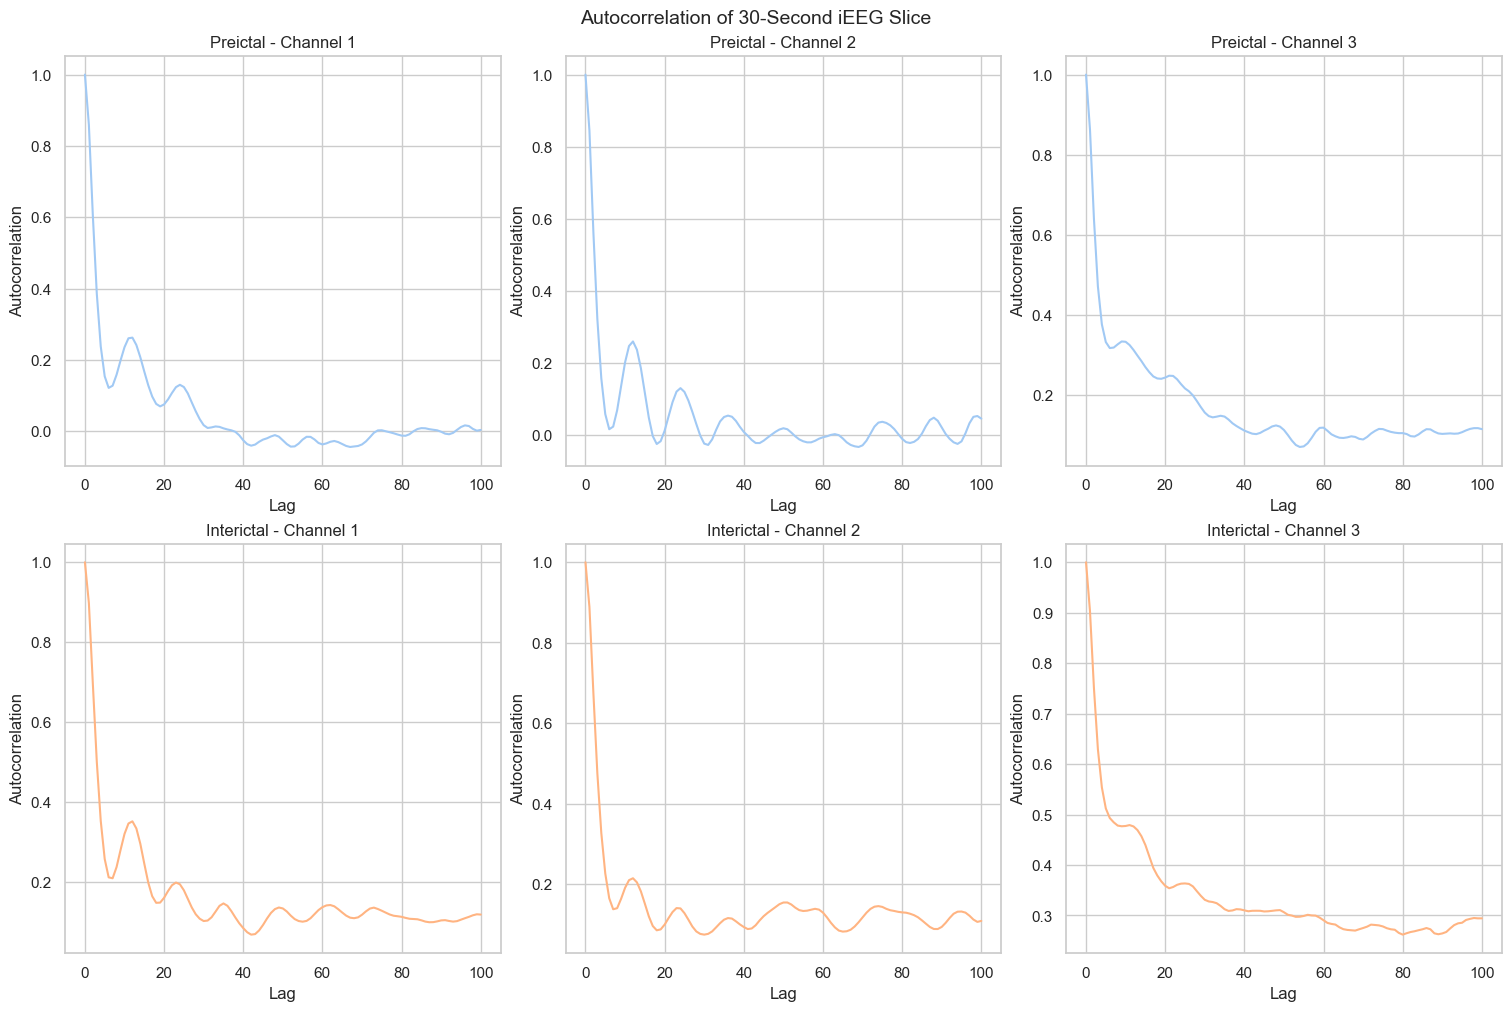

In [44]:
from statsmodels.tsa.stattools import acf

idx_eeg_slice_to_plot = 10
preictal_30s_slice = all_preictal_slices[idx_eeg_slice_to_plot]
interictal_30s_slice = all_interictal_slices[idx_eeg_slice_to_plot]

# Select 3 channels to compare (indices can be adjusted)
selected_channels = [0, 1, 2]
lags = 100  # Number of lags to display

# Prepare autocorrelations for both slices
autocorrs_preictal = {ch: acf(preictal_30s_slice[ch], nlags=lags) for ch in selected_channels}
autocorrs_interictal = {ch: acf(interictal_30s_slice[ch], nlags=lags) for ch in selected_channels}

# Plotting with seaborn: 2 rows, 3 columns (3 channels per row)
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()

# Plot preictal autocorrelations (first row)
for i, ch in enumerate(selected_channels):
    sns.lineplot(x=range(lags+1), y=autocorrs_preictal[ch], ax=axes[i], color=preictal_color)
    axes[i].set_title(f"Preictal - Channel {ch + 1}")
    axes[i].set_xlabel("Lag")
    axes[i].set_ylabel("Autocorrelation")

# Plot interictal autocorrelations (second row)
for i, ch in enumerate(selected_channels):
    sns.lineplot(x=range(lags+1), y=autocorrs_interictal[ch], ax=axes[i + 3], color=interictal_color)
    axes[i + 3].set_title(f"Interictal - Channel {ch + 1}")
    axes[i + 3].set_xlabel("Lag")
    axes[i + 3].set_ylabel("Autocorrelation")

fig.suptitle(f"Autocorrelation of 30-Second iEEG Slice", fontsize=14)
plt.show()


Observations:
 - The time domain features of the signal within a single channel are correlated. A PCA could then be used two reduce such "redundancy" of information in the time domain, reducing the number of time domain features for each channel

## Analysis of iEEG Signals in Frequency Domain

### Short Time Fourier Transform (STFT) plots for single channel

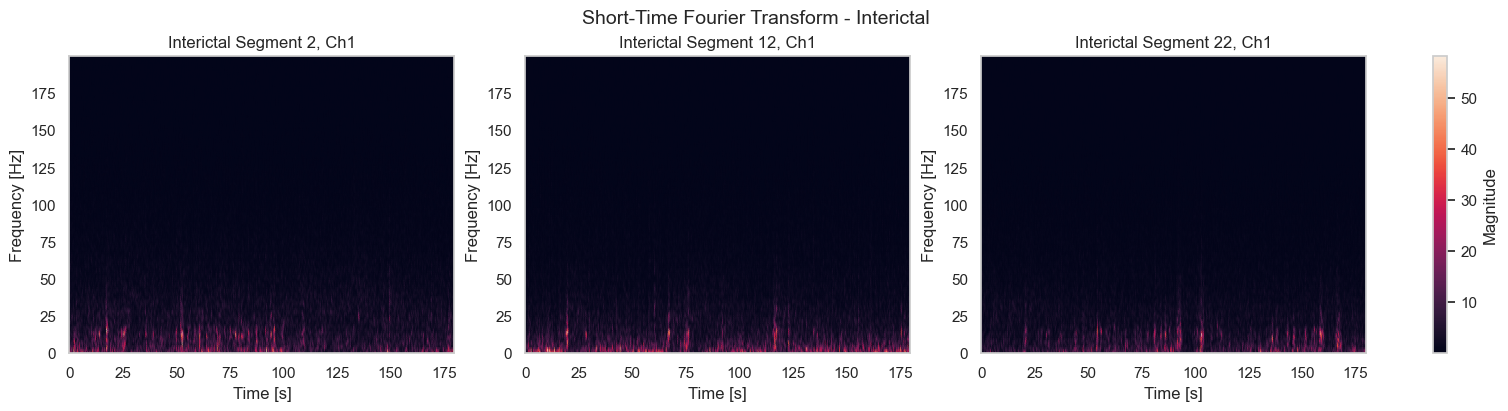

In [70]:
# Set the range of segments to plot
segments_to_plot = [2, 12, 22]  # Change this list to any segment numbers you want to plot
ch_to_plot = 1

# Create a figure with a single row and columns equal to the number of segments
num_segments = len(segments_to_plot)

# Create the subplot layout (1 row, num_segments columns)
fig, axes = plt.subplots(1, num_segments, figsize=(5 * num_segments, 4), constrained_layout=True)

# Loop through each segment and plot its STFT
for idx, segment_to_plot in enumerate(segments_to_plot):
    # Get the specific segment data
    interictal_segment_to_plot = interictal_training[segment_to_plot-1]

    fs = interictal_segment_to_plot["sampling_frequency"]
    time_window = 180
    samples_window = round(fs * time_window)

    signal = interictal_segment_to_plot["eeg_data"][ch_to_plot-1, 0:samples_window-1]

    # Compute the Short-Time Fourier Transform (STFT)
    f, t_stft, Zxx = stft(signal, fs, nperseg=256)

    # Plot the STFT for this segment
    ax = axes[idx]  # Access the appropriate subplot
    c = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
    ax.set_title(f'Interictal Segment {segment_to_plot}, Ch{ch_to_plot}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    
fig.colorbar(c, ax=axes, orientation='vertical', label='Magnitude')
fig.suptitle(f"Short-Time Fourier Transform - Interictal", fontsize=14)
plt.show()


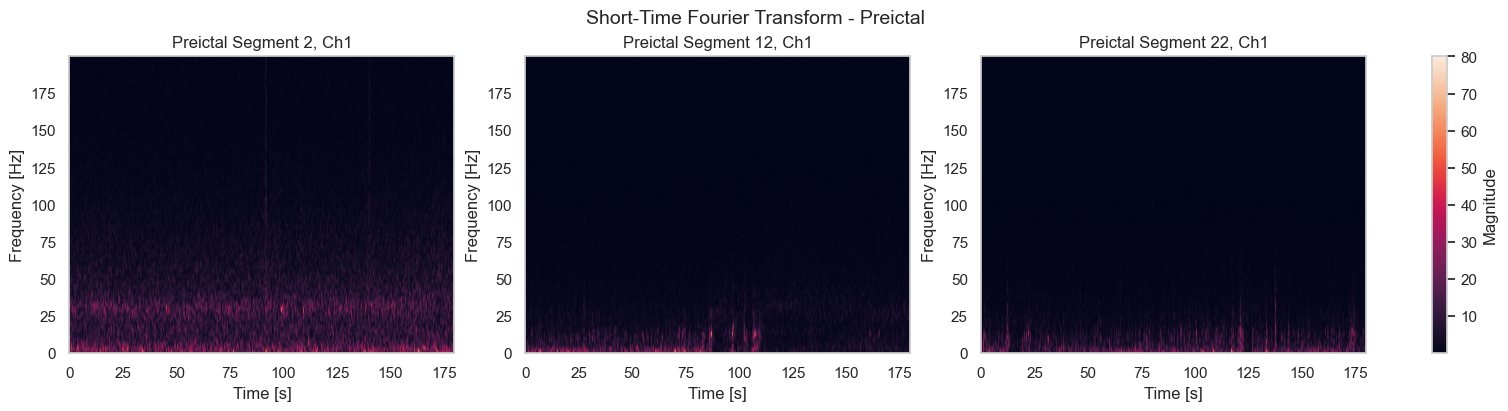

In [69]:
import matplotlib.pyplot as plt
from scipy.signal import stft

# Set the range of segments to plot
segments_to_plot = [2, 12, 22]  # Change this list to any segment numbers you want to plot
ch_to_plot = 1

# Create a figure with a single row and columns equal to the number of segments
num_segments = len(segments_to_plot)

# Create the subplot layout (1 row, num_segments columns)
fig, axes = plt.subplots(1, num_segments, figsize=(5 * num_segments, 4), constrained_layout=True)

# Loop through each segment and plot its STFT
for idx, segment_to_plot in enumerate(segments_to_plot):
    # Get the specific segment data
    preictal_segment_to_plot = preictal_training[segment_to_plot-1]

    fs = preictal_segment_to_plot["sampling_frequency"]
    time_window = 180
    samples_window = round(fs * time_window)

    signal = preictal_segment_to_plot["eeg_data"][ch_to_plot-1, 0:samples_window-1]

    # Compute the Short-Time Fourier Transform (STFT)
    f, t_stft, Zxx = stft(signal, fs, nperseg=256)

    # Plot the STFT for this segment
    ax = axes[idx]  # Access the appropriate subplot
    c = ax.pcolormesh(t_stft, f, np.abs(Zxx), shading='gouraud')
    ax.set_title(f'Preictal Segment {segment_to_plot}, Ch{ch_to_plot}')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')

fig.colorbar(c, ax=axes, orientation='vertical', label='Magnitude')
fig.suptitle(f"Short-Time Fourier Transform - Preictal", fontsize=14)
plt.show()


Observations:
- In both cases, the energy is more concentrated across lower frequencies, particularly concentrated around the 0-50 Hz range, which is typical for EEG signals.
- Both preictal and interictal data doesn't seem to contain a lot of noise. There are just a few abrupt changes in the power of frequency bands.
    - One example of this abrupt change can be seen around 100s in the preictal segments 2 and 12. Probably, this was caused by an artifact or noise (muscle movements, electrode shifts, or electrical interference)

### Comparison STFT plots across classes and channels

#### Segment 2 Example

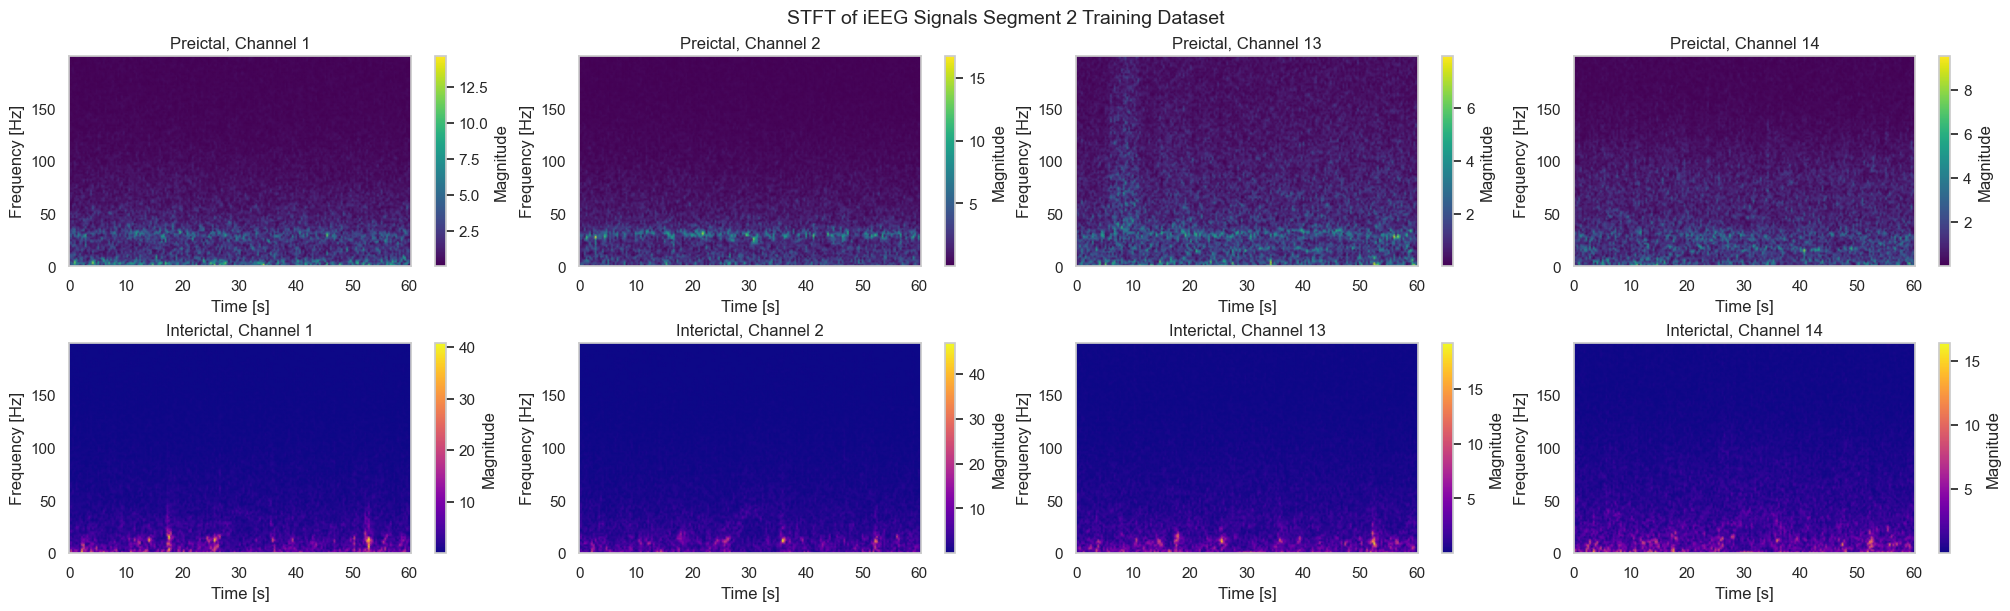

In [47]:
# Parameters
segment_to_plot = 2
channels_to_plot = [1, 2, 13, 14]
time_window = 60

# Extract sampling frequency
sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

# Compute the number of samples in the desired time window
samples_window = round(sampling_freq * time_window)

# Initialize time vector for plotting
time = np.arange(samples_window) / sampling_freq

# Create subplots
fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(20, 6), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    # Extract EEG data for the current channel and segment
    preictal_data = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_data = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    # Compute STFT for preictal data
    f_pre, t_pre, Zxx_pre = stft(preictal_data, fs=sampling_freq, nperseg=256)
    f_inter, t_inter, Zxx_inter = stft(interictal_data, fs=sampling_freq, nperseg=256)

    # Plot STFT for preictal data
    pcm1 = axes[0][idx].pcolormesh(t_pre, f_pre, np.abs(Zxx_pre), shading='gouraud', cmap='viridis')
    fig.colorbar(pcm1, ax=axes[0][idx], label='Magnitude')
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[0][idx].set_ylabel("Frequency [Hz]")
    axes[0][idx].set_xlabel("Time [s]")

    # Plot STFT for interictal data
    pcm2 = axes[1][idx].pcolormesh(t_inter, f_inter, np.abs(Zxx_inter), shading='gouraud', cmap='plasma')
    fig.colorbar(pcm2, ax=axes[1][idx], label='Magnitude')
    axes[1][idx].set_title(f"Interictal, Channel {channel}")
    axes[1][idx].set_ylabel("Frequency [Hz]")
    axes[1][idx].set_xlabel("Time [s]")

fig.suptitle(f"STFT of iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)
plt.show()


#### Segment 12 Example

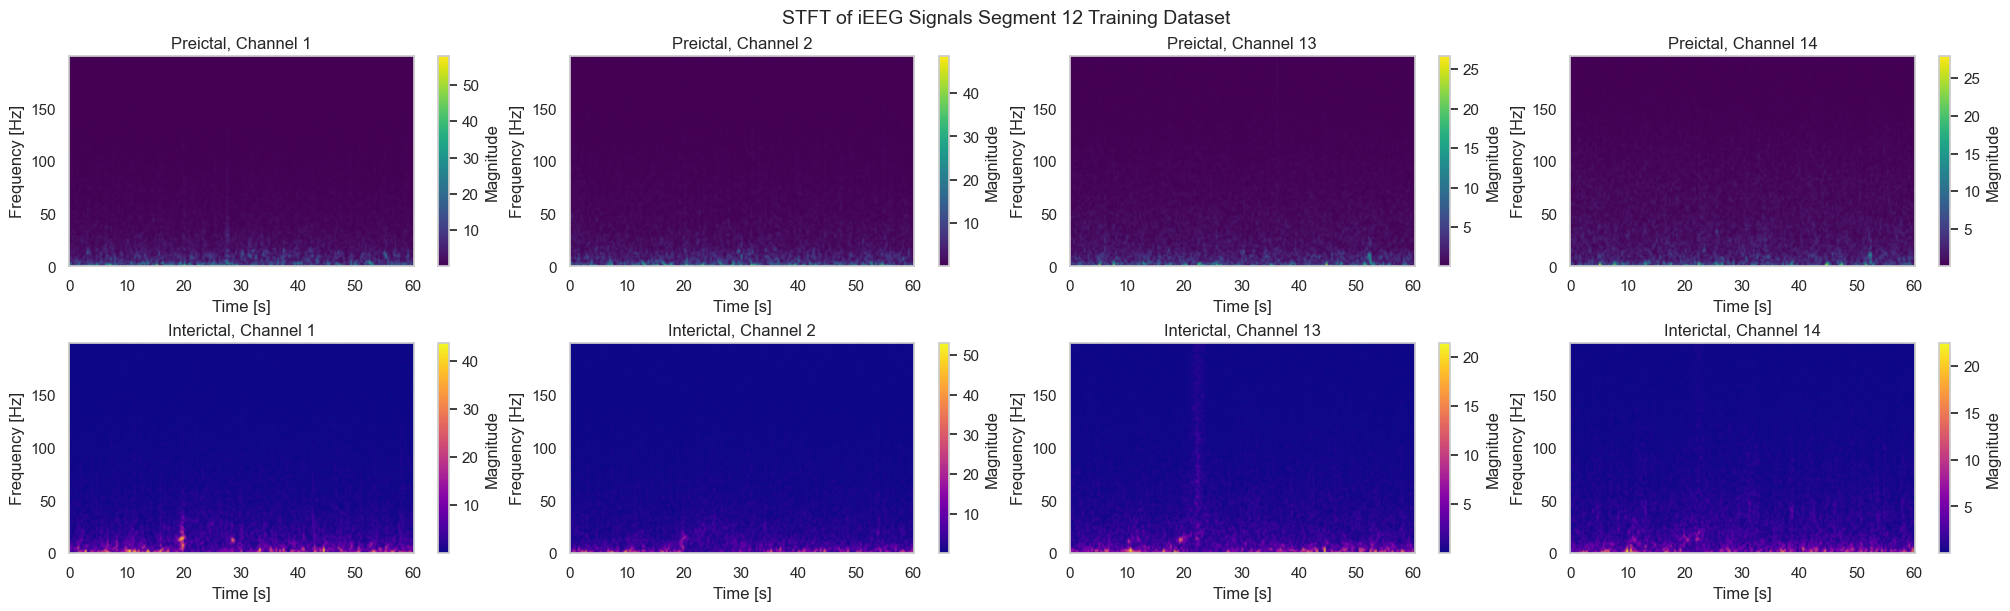

In [71]:
# Parameters
segment_to_plot = 12
channels_to_plot = [1, 2, 13, 14]
time_window = 60

# Extract sampling frequency
sampling_freq = preictal_training[segment_to_plot - 1]["sampling_frequency"]

# Compute the number of samples in the desired time window
samples_window = round(sampling_freq * time_window)

# Initialize time vector for plotting
time = np.arange(samples_window) / sampling_freq

# Create subplots
fig, axes = plt.subplots(2, len(channels_to_plot), figsize=(20, 6), constrained_layout=True)

for idx, channel in enumerate(channels_to_plot):
    # Extract EEG data for the current channel and segment
    preictal_data = preictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]
    interictal_data = interictal_training[segment_to_plot - 1]["eeg_data"][channel - 1, 0:samples_window]

    # Compute STFT for preictal data
    f_pre, t_pre, Zxx_pre = stft(preictal_data, fs=sampling_freq, nperseg=256)
    f_inter, t_inter, Zxx_inter = stft(interictal_data, fs=sampling_freq, nperseg=256)

    # Plot STFT for preictal data
    pcm1 = axes[0][idx].pcolormesh(t_pre, f_pre, np.abs(Zxx_pre), shading='gouraud', cmap='viridis')
    fig.colorbar(pcm1, ax=axes[0][idx], label='Magnitude')
    axes[0][idx].set_title(f"Preictal, Channel {channel}")
    axes[0][idx].set_ylabel("Frequency [Hz]")
    axes[0][idx].set_xlabel("Time [s]")

    # Plot STFT for interictal data
    pcm2 = axes[1][idx].pcolormesh(t_inter, f_inter, np.abs(Zxx_inter), shading='gouraud', cmap='plasma')
    fig.colorbar(pcm2, ax=axes[1][idx], label='Magnitude')
    axes[1][idx].set_title(f"Interictal, Channel {channel}")
    axes[1][idx].set_ylabel("Frequency [Hz]")
    axes[1][idx].set_xlabel("Time [s]")

fig.suptitle(f"STFT of iEEG Signals Segment {segment_to_plot} Training Dataset", fontsize=14)
plt.show()

### Spectral Energy per Frequency Band

In this section, the spectral power are calculated of 8 predefined frequency bands are calculated over 30s-long preictal and interictal iEEG slices. The slices are taken from a subset the training set.

In [17]:
# Function to calculate FFT and group power into frequency bands
def calculate_band_power(eeg_data, bands, fs):
    # Compute the FFT
    fft_vals = np.fft.fft(eeg_data)
    freqs = np.fft.fftfreq(len(eeg_data), 1/fs)
    
    # Only take the positive half of the frequencies and corresponding FFT values
    positive_freqs = freqs[:len(freqs)//2]
    positive_fft_vals = np.abs(fft_vals[:len(fft_vals)//2])
    
    # Group FFT values into bands
    band_powers = []
    for i in range(1, len(bands)):
        band_mask = (positive_freqs >= bands[i-1]) & (positive_freqs < bands[i])
        band_power = np.sum(positive_fft_vals[band_mask])
        band_powers.append(np.log10(band_power) if band_power > 0 else 0)  # Apply log scaling
    
    return band_powers

In [ ]:
sample_segments_idx = range(0, 20)
sample_channel = 5
slice_time_duration = 30

sample_preictal_segments = [preictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]
sample_interictal_segments =  [interictal_training[segment_idx]["eeg_data"] for segment_idx in sample_segments_idx]

fs = preictal_training[0]["sampling_frequency"]

# ALl 30s-long EGG slices are stored in the following lists
all_preictal_slices = []
all_interictal_slices = []

for eeg_segment in sample_preictal_segments:
    all_preictal_slices = all_preictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)
    
for eeg_segment in sample_interictal_segments:
    all_interictal_slices = all_interictal_slices + eeg_slices(eeg_segment, fs, slice_time_duration)

In [19]:
print("Number of preictal 30s slices: ", len(all_preictal_slices))
print("Number of interictal 30s slices: ", len(all_interictal_slices))

Number of preictal 30s slices:  400
Number of interictal 30s slices:  400


In [20]:
# Frequency bands
bands = [0.1, 4, 8, 12, 30, 50, 70, 100, 180]
band_labels = ["0.1-4", "4-8", "8-12", "12-30", "30-50", "50-70", "70-100", "100-180"]

# Collect band powers for each EEG preictal slice
all_band_powers_preictal = []

for eeg_slice in all_preictal_slices:
    band_powers = calculate_band_power(eeg_slice[sample_channel-1, :], bands, fs)
    all_band_powers_preictal.append(band_powers)

# Convert the list of band powers into a pandas dataframe for easy plotting
all_band_powers_preictal_df = pd.DataFrame(all_band_powers_preictal, columns=band_labels)
all_band_powers_preictal_df["Label"] = "Preictal"

# Collect band powers for each EEG interictal slice
all_band_powers_interictal = []

for eeg_slice in all_interictal_slices:
    band_powers = calculate_band_power(eeg_slice[sample_channel-1, :], bands, fs)
    all_band_powers_interictal.append(band_powers)

# Convert the list of band powers into a pandas dataframe for easy plotting
all_band_powers_interictal_df = pd.DataFrame(all_band_powers_interictal, columns=band_labels)
all_band_powers_interictal_df["Label"] = "Interictal"

all_power_bands_combined_df = pd.concat([all_band_powers_interictal_df, all_band_powers_preictal_df])
all_power_bands_combined_df

,0.1-4,4-8,8-12,12-30,30-50,50-70,70-100,100-180,Label
0,6.163330,5.787300,5.708130,6.193116,6.115610,5.858795,5.755010,5.754509,Interictal
1,6.108644,5.649446,5.546247,6.109427,6.097398,5.858698,5.776529,5.752845,Interictal
2,6.261237,5.871508,5.853210,6.347782,6.078515,5.820069,5.733242,5.746044,Interictal
3,6.522892,5.835683,5.871315,6.366684,6.144789,5.947799,5.963053,6.152249,Interictal
4,6.472857,5.976099,5.880419,6.211270,5.965209,5.725032,5.683613,5.735830,Interictal
...,...,...,...,...,...,...,...,...,...
395,5.835388,5.851181,5.728282,6.209831,6.121505,5.941194,5.824768,5.786141,Preictal
396,5.749902,5.793272,5.680822,6.187655,6.093828,5.825930,5.737791,5.737693,Preictal
397,5.816875,5.841428,5.779451,6.252791,6.125268,5.848493,5.762842,5.764955,Preictal
398,5.810152,5.785356,5.699287,6.243121,6.144263,5.935525,5.892459,6.006304,Preictal


In [ ]:
# Melt the dataframe to reshape it for the ANOVA Test and plotting
melted_df = all_power_bands_combined_df.melt(id_vars=['Label'], var_name='Frequency Bands [Hz]', value_name='Log10 Power')
melted_df

,Label,Frequency Bands [Hz],Log10 Power
0,Interictal,0.1-4,6.163330
1,Interictal,0.1-4,6.108644
2,Interictal,0.1-4,6.261237
3,Interictal,0.1-4,6.522892
4,Interictal,0.1-4,6.472857
...,...,...,...
6395,Preictal,100-180,5.786141
6396,Preictal,100-180,5.737693
6397,Preictal,100-180,5.764955
6398,Preictal,100-180,6.006304


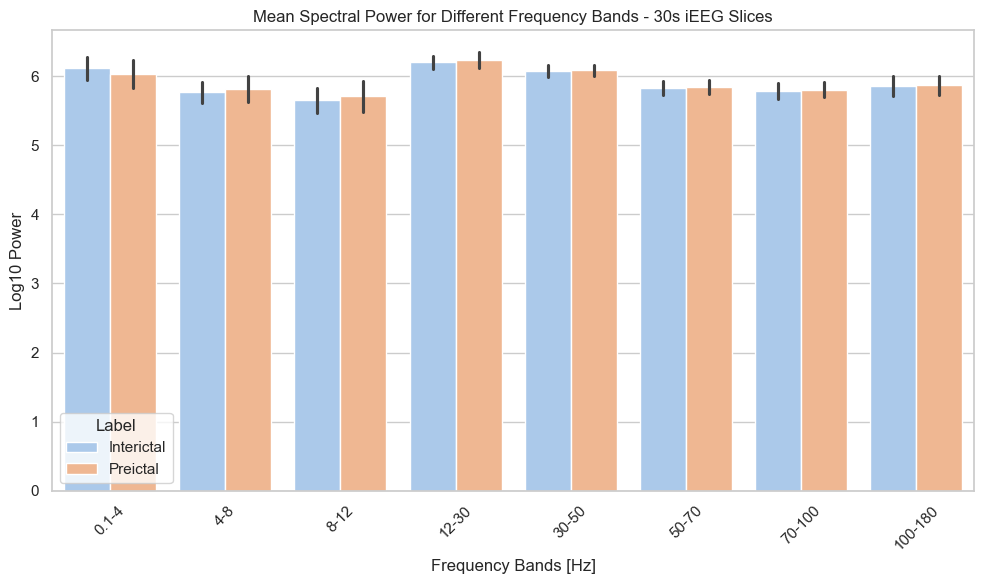

In [35]:
# Plot the barplot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency Bands [Hz]', y='Log10 Power', data=melted_df, hue='Label', errorbar="sd", palette="pastel", hue_order=["Interictal", "Preictal"])

# Customize the plot
plt.xlabel("Frequency Bands [Hz]")
plt.ylabel("Log10 Power")
plt.title("Mean Spectral Power for Different Frequency Bands - 30s iEEG Slices")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### ANOVA Hypothesis Test

##### Goal
The goal of this two-way ANOVA test is to investigate whether the spectral energy of EEG signals varies significantly across eight predefined frequency bands and between two classes of EEG data.
- By examining whether spectral energy differs across the eight frequency bands, we aim to identify frequency ranges that may hold distinctive information about the EEG data. Significant variation in energy across these bands would suggest that certain frequency ranges contribute more strongly to the signal's characteristics.
- If the spectral energy varies significantly between interictal and preictal states, this would indicate that these frequency-specific features could serve as effective discriminators for the classification task.

##### Null Hypotheses (H₀) for the Two-Way ANOVA
1. **Main Effect of Frequency Bands**:  
   H₀₁: The mean log10 spectral power does not vary across frequency bands.  
   (i.e., there is no significant difference in spectral power between frequency bands.)

2. **Main Effect of EEG Class**:  
   H₀₂: The mean log10 spectral power does not vary between interictal and preictal EEG classes.  
   (i.e., there is no significant difference in spectral power between the two EEG classes.)

3. **Interaction Effect**:  
   H₀₃: There is no interaction effect between frequency bands and EEG class on log10 spectral power.  
   (i.e., the difference in spectral power across frequency bands does not depend on the EEG class.)


##### Conditions for Rejection:
- For any hypothesis, the null hypothesis is rejected if the corresponding **p-value** from the ANOVA test is **less than the significance level (α)**.  
- Typically, α = 0.05 is used as the threshold for statistical significance.  
  - If **p-value < 0.05**, reject H₀ (significant effect exists).  
  - If **p-value ≥ 0.05**, fail to reject H₀ (no significant effect).  

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

new_column_names = ["label", "freq", "power"]
melted_df.columns = new_column_names

# Ensure the column names match your melted DataFrame
# melted_df has columns: 'label', 'Frequency Bands [Hz]', 'Log10 Power'

# Perform two-way ANOVA
model = ols("power ~ C(label) + C(freq) + C(label):C(freq)", 
            data=melted_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table

# Display results
anova_table
# df: degrees of freedom
# F: F-statistic
# PR(>F): p-value

,sum_sq,df,F,PR(>F)
C(label),0.339927,1.0,16.377256,5.251729e-05
C(freq),189.693048,7.0,1305.597981,0.000000e+00
C(label):C(freq),2.499851,7.0,17.205691,1.039043e-22
Residual,132.506378,6384.0,NaN,NaN


##### Conclusion
Since the p-values are all very small, H₀₁, H₀₂ and H₀₃ are rejected. Therefore,
- spectral power significantly varies across frequency bands;
- spectral power significantly differs between interictal and preictal classes;
- the effect of frequency bands on spectral power depends on the EEG class.

Such results suggest that the spectral power of these 8 frequency bands could serve as good features to discriminate the preictal and interictal states

##### ANOVA Slide Summary (Support)

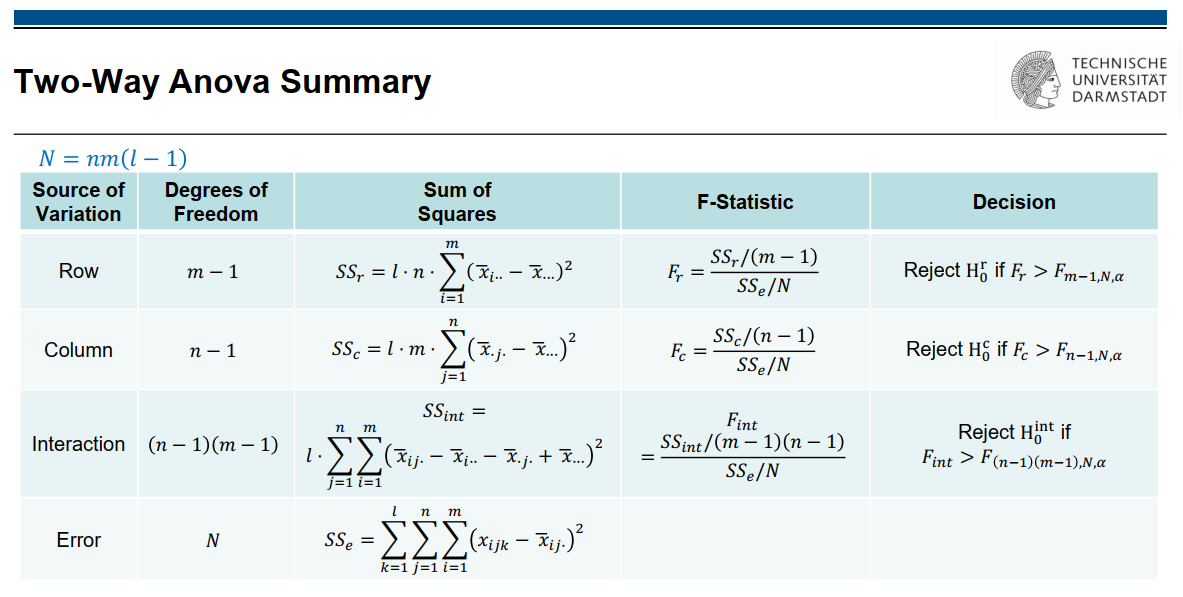